In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
import graphlab
import unicodedata
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib


startup script successful


In [45]:
from nltk.stem import WordNetLemmatizer
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")

from nltk.corpus import stopwords
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people', 'wa', 'ha', 'let', 'get', 'time', 'data']

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]

def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height, '{}'.format(features[feature_id]))
        feature_id+=1

In [46]:
crunch_data=pd.read_csv('overall_company_list.csv')
kickstart_data=pd.read_csv('proj_list_tech_top200pages_full.csv')
angellist_data=pd.read_csv('results_so_far_2016101710pm.csv')
# unify the column name
kickstart_data.rename(columns={'description':'Description'},inplace=True)
angellist_data.rename(columns={'product_desc':'Description'},inplace=True)
#merge data
merge_data=crunch_data.append([kickstart_data,angellist_data])
# remove \n from descriptions
merge_data['Description']=merge_data['Description'].str.replace('\n',' ')
merge_data=merge_data.dropna(subset=['Description'])

In [47]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=2,
                                max_features=3000,
                                tokenizer=LemmaTokenizer(),
                                stop_words=stop_list)
tf = tf_vectorizer.fit_transform(merge_data['Description'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [48]:
i=10
print "original description"
print merge_data.iloc[i]['Description']
print "number of features", tf[i].sum()
print "extracted features"
print [tf_feature_names[idx] for idx in list(tf[i].nonzero()[1])] 

original description
Nanigans advertising automation software powers the world’s leading in-house performance marketing teams.
number of features 9
extracted features
[u'team', u'performance', u'house', u'leading', u'software', u'automation', u'advertising', u'power', u'marketing']


In [6]:
# build the LDA model

In [80]:
lda = LatentDirichletAllocation(n_topics=15, max_iter=200,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=0,n_jobs=-1, verbose=1)
lda.fit(tf)
topic_feature=lda.transform(tf)
topic_feature_norm=normalize(topic_feature)

(array([   29.,   273.,  2135.,  4208.,  4767.,  3455.,  2245.,  1483.,
         1367.,   629.]),
 array([ 0.06666667,  0.15805555,  0.24944443,  0.34083332,  0.4322222 ,
         0.52361108,  0.61499996,  0.70638885,  0.79777773,  0.88916661,
         0.9805555 ]),
 <a list of 10 Patch objects>)

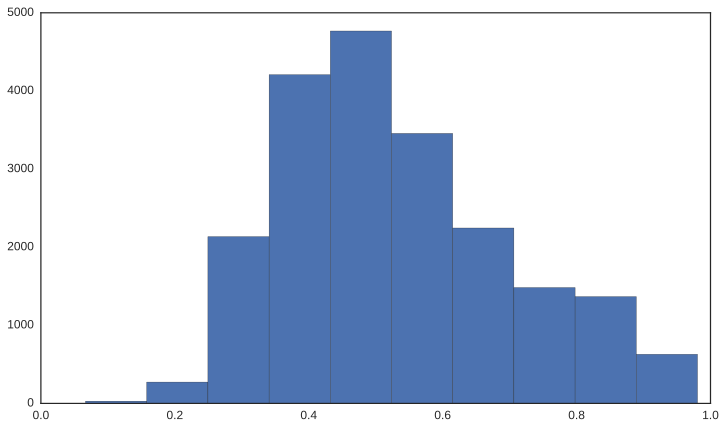

In [82]:
hist(np.max(topic_feature,axis=1))

Topic #0:
search real online network social find user community share discover
Topic #1:
smart device first power light sensor system arduino energy control
Topic #2:
business online customer consumer store product payment retailer card local
Topic #3:
health job patient care cost student save healthcare company medical
Topic #4:
com http www product learn school kid u student child
Topic #5:
open source 3d design high project internet build quality reality
Topic #6:
app video photo phone mobile android io iphone free call
Topic #7:
one need email work like simple team easy thing every
Topic #8:
learning customer company platform machine insight business analytics tool decision
Topic #9:
mobile user application platform web app apps based developer location
Topic #10:
social content platform brand medium marketing customer game music video
Topic #11:
home food car travel service experience city demand delivery fun
Topic #12:
analytics intelligence company marketing platform business re

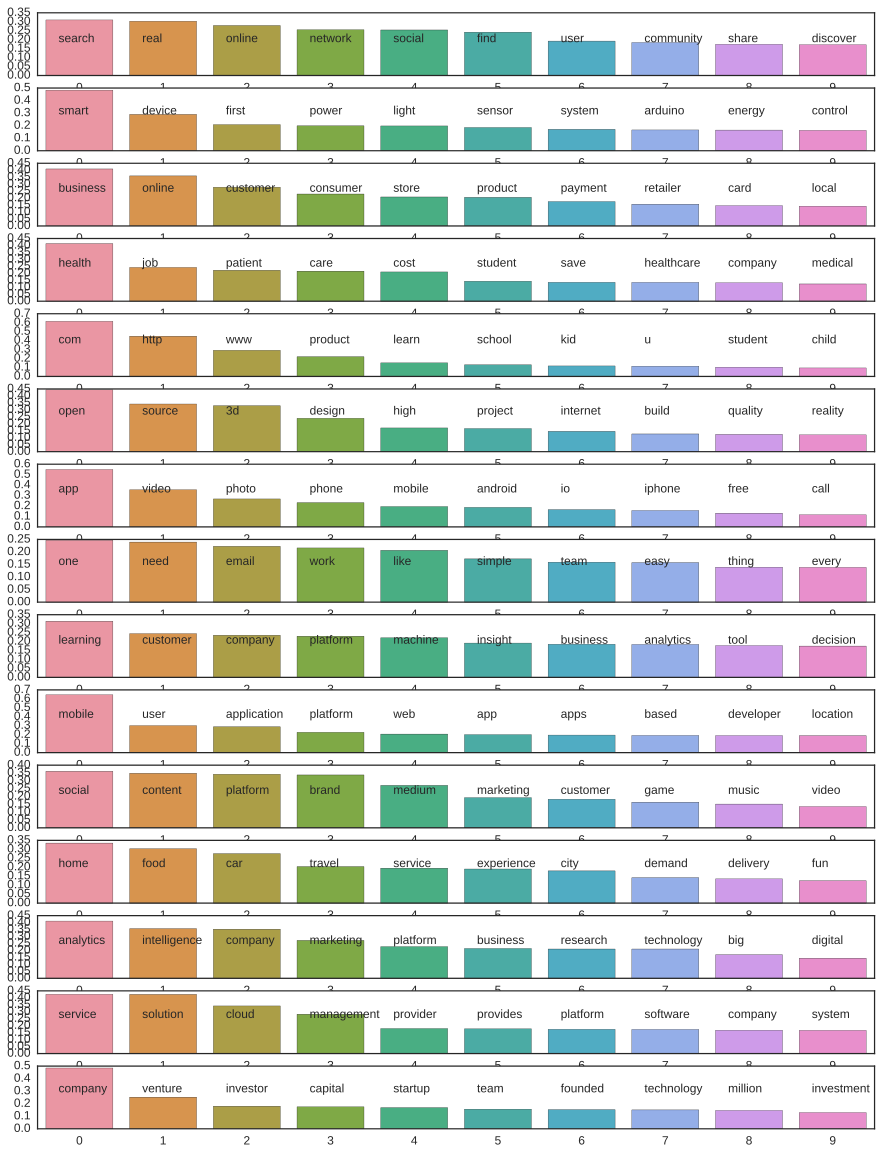

In [83]:
fig=figure(figsize=(15,20))
for i in range(15):
    subplot(15,1,i+1)
    plot_top_words(lda,tf_feature_names,i)

In [51]:
import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [52]:
def plot_cluster(model, features, tsne_features, feature_names, nmf_model=lda):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1
def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']


In [ ]:
# agglomerative clustering

In [39]:
from sklearn.cluster import AgglomerativeClustering

In [86]:
agg= AgglomerativeClustering(n_clusters=20, linkage='ward')
agg.fit(topic_feature_norm)
metrics.calinski_harabaz_score(topic_feature_norm, agg.labels_) 

1761.9968963387739

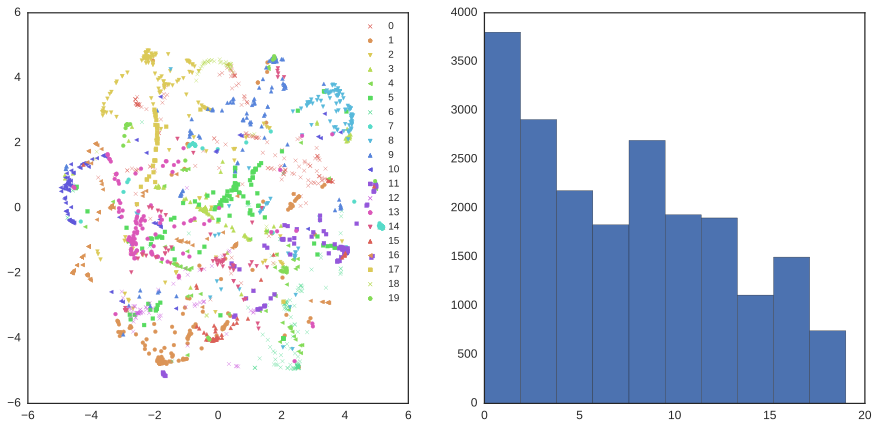

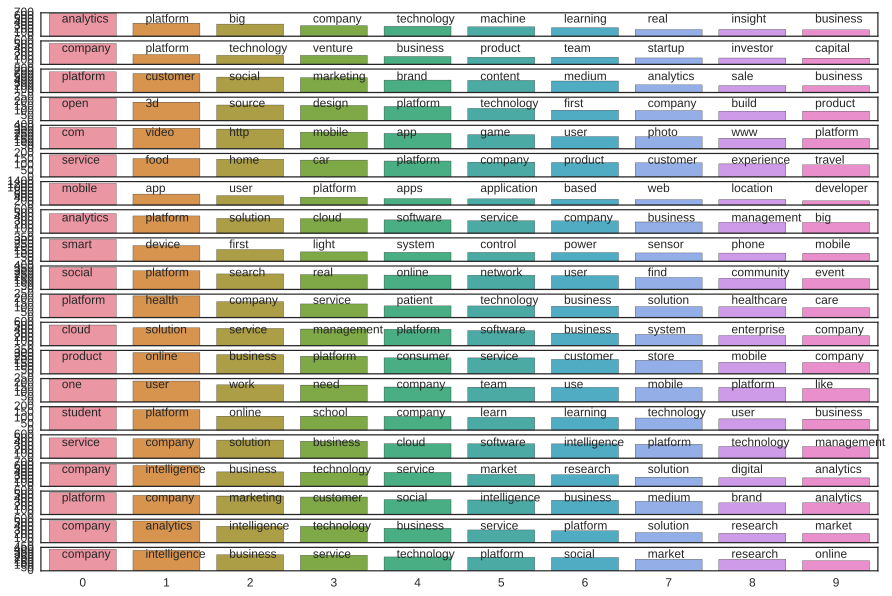

In [87]:
plot_cluster(agg, topic_feature, topic_feature_norm, tf_feature_names)

In [44]:
print_cluster_member(agg, 1, merge_data, 15)

number of companies in this class: 1308
company ID: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
company ID: 12
Narrative Science is the leader in Advanced Natural Language Generation for the enterprise, generating data-driven narratives at scale.
company ID: 16
Diffbot is an AI startup that provides knowledge as a service to power intelligent applications.
company ID: 21
Advanced medication adherence solutions powered by artificial intelligence
company ID: 26
The consumer goods industry’s leading real-time image recognition retail solution.
company ID: 39
Meta is an Artificial Intelligence that continuously maps and monitors the universe of science, as well as its future horizons.
company ID: 53
VocalZoom mission to enable Voice control and Voice Authentication. Multifunction Sensors Enable Human Machine communication.
company ID: 56
NeuroVision Imaging, a developer of digital imaging and diagnostic solutions for Alzhei

In [55]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(20, 0.4)
neigh.fit(topic_feature_norm) 

In [56]:
def query_company(id, knn_model=neigh, data_set=merge_data, X=topic_feature_norm):
    k=10
    print 'query id:', id
    print data_set.iloc[id]['Description']
    print '-'*50
    distances, indices = knn_model.kneighbors(X[id].reshape(1, -1),n_neighbors=k)
    for i in range(1,k):
        print '{}st neighbor: id {}, with distance {}'.format(i,indices[0][i],distances[0][i])
        print  data_set.iloc[indices[0][i]]['Description']
        print 

NameError: name 'neigh' is not defined

In [ ]:
query_company(3)